In [1]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV

from sklearn.metrics import plot_roc_curve, roc_auc_score

from sklearn.feature_selection import RFE

from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
RANDOM_SEED = 8    # Set a random seed for reproducibility!

from sklearn.metrics import plot_confusion_matrix, recall_score,accuracy_score, precision_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier,VotingClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from numpy import nan
import pandas as pd
import copy

In [2]:
features_df = pd.read_csv(
    "data/training_set_features.csv", 
    index_col="respondent_id"
)
labels_df = pd.read_csv(
   "data/training_set_labels.csv", 
    index_col="respondent_id"
)

In [3]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
non_numeric_cols = features_df.columns[features_df.dtypes == 'object'].values

In [4]:
seperate_processing_cols = ["age_group", "income_poverty"]
#seperate_processing_cols = []

age_mean_map = {'18 - 34 Years': 26,
                '35 - 44 Years': 40,
                '45 - 54 Years': 50,
                '55 - 64 Years': 60,
                '65+ Years': 70, 
                }

income_map = {'Below Poverty': 1,
              '<= $75,000, Above Poverty': 2,
              '> $75,000':3
             }

full_map = {"age_group":age_mean_map,
            "income_poverty":income_map}

def map_to_numeric(x, mapping):
    if mapping.get(x) == None:
        return nan
    else:
        return mapping.get(x)

def convert(df):
    new_df = copy.deepcopy(df)
    for col in seperate_processing_cols:
        new_df[col] = df[col].apply(lambda x: map_to_numeric(x, full_map.get(col))) 
    return new_df

numeric_to_cat_transformer = FunctionTransformer(convert)  

In [5]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
high_missing_cols = []
non_numeric_cols = [x for x in non_numeric_cols if (x not in high_missing_cols and x not in seperate_processing_cols)]
numeric_cols = [x for x in numeric_cols if (x not in high_missing_cols and x not in seperate_processing_cols)]
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_to_cat_preprocessing_steps = Pipeline([
    ('convert_to_cat', numeric_to_cat_transformer),
    ('simple_imputer', SimpleImputer(strategy='mean')),
    ('standard_scaler', StandardScaler()),
    ])

numeric_preprocessing_steps = Pipeline(steps=[
    ('standard_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean'))])
non_numeric_preprocessing_steps = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
total_preprocessing= ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("non_numeric",non_numeric_preprocessing_steps,non_numeric_cols),
        ("numeric_to_cat", numeric_to_cat_preprocessing_steps, seperate_processing_cols)
    ],
    remainder = "drop"
)

In [ ]:
#scoring function (cross_val)
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=5):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

In [ ]:
#scoring function (aoc-roc)
class ModelWithAOCROC(ModelWithCV):
    """Structure for scoring classfication models"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def plt_roc_curve(self,X=None,y=None):
      
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y
        y_preds = self.model.predict(cv_X)
        plot_roc_curve(self.model,cv_X,cv_y)

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df['seasonal_vaccine'],
    test_size=0.33,
    shuffle=True,
    stratify=labels_df['seasonal_vaccine'],
    random_state=RANDOM_SEED
)

In [9]:
dummy = DummyClassifier()
dummy.fit(X_train,y_train)

DummyClassifier()

In [10]:
dummy_scoring = ModelWithAOCROC(dummy,'dummy',X_train,y_train)

In [11]:
dummy_scoring.print_cv_summary()

CV Results for `dummy` model:
            0.53440 ± 0.00015 accuracy
        


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


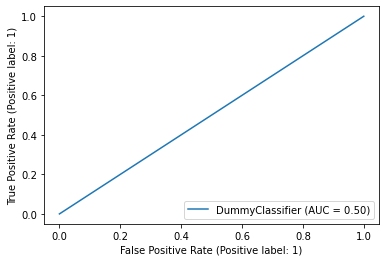

In [12]:
dummy_scoring.plt_roc_curve()

In [14]:
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=5, step=1)

log_reg_pipe=Pipeline([('total_preprocessing',total_preprocessing),
                     ('rfe_logreg',selector)])


# log_reg_pipe.fit(X_train,y_train)

In [ ]:
logreg_scoring=ModelWithAOCROC(log_reg_pipe, 'logreg', X_train, y_train, cv_now = Fasle)

In [ ]:
logreg_scoring.print_cv_summary()

In [18]:
logreg_scoring.plt_roc_curve()

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [29]:
rfc_pipe=Pipeline([('total_preprocessing',total_preprocessing),
                     ('rfc',RandomForestClassifier(random_state=42))])

In [30]:
rfc_pipe.fit(X_train,y_train)

Pipeline(steps=[('total_preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                      

In [107]:
labels_df['h1n1_vaccine'].value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

In [31]:
rfc_scoring=ModelWithAOCROC(rfc_pipe, 'rfc_pipe', X_train, y_train, cv_now=True)

In [32]:
rfc_scoring.print_cv_summary()

CV Results for `rfc_pipe` model:
            0.77611 ± 0.00900 accuracy
        


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


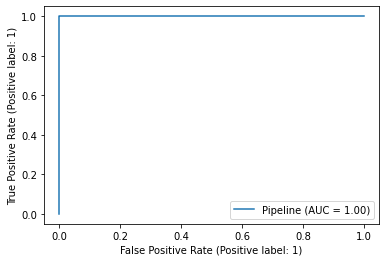

In [33]:
#scoring with aoc-roc
rfc_scoring.plt_roc_curve()

In [37]:
etc = ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42)
etc_pipe= Pipeline([('total_preprocessing',total_preprocessing), ('etc', etc)])

In [38]:
#fitting on training data 
etc_pipe.fit(X_train,y_train)

Pipeline(steps=[('total_preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                      

In [39]:
#instantiating scoring function 
etc_scoring=ModelWithAOCROC(etc_pipe, 'etc_pipe', X_train, y_train, cv_now=True)

In [40]:
#scoring with Cross_val
etc_scoring.print_cv_summary

<bound method ModelWithCV.print_cv_summary of <__main__.ModelWithAOCROC object at 0x7fcceb5c0b20>>

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


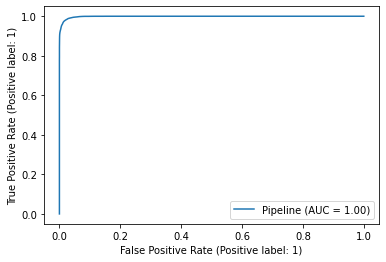

In [41]:
etc_scoring.plt_roc_curve()

In [42]:
gbc_pipe = Pipeline([('total_preprocessing',total_preprocessing), ('gbc', GradientBoostingClassifier(random_state=42))])

In [43]:
#fitting on training data 
gbc_pipe.fit(X_train,y_train)

Pipeline(steps=[('total_preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                      

In [44]:
#instantiating scoring function 
gbc_scoring=ModelWithAOCROC(gbc_pipe, 'gbc_pipe', X_train, y_train, cv_now=True)

In [45]:
#scoring with Cross_val
gbc_scoring.print_cv_summary()

CV Results for `gbc_pipe` model:
            0.78332 ± 0.00949 accuracy
        


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


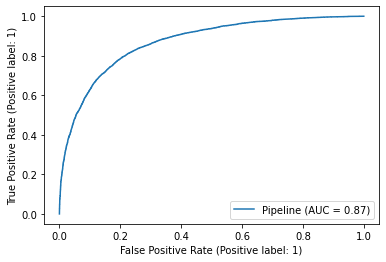

In [46]:
gbc_scoring.plt_roc_curve()

In [47]:
vc = VotingClassifier(estimators=[
    ('logreg', LogisticRegression()),
    ('knn', KNeighborsClassifier(n_neighbors=3)),
    ('ct', DecisionTreeClassifier(random_state=42))
])

In [48]:
vc_pipe=Pipeline([('total_preprocessing',total_preprocessing), ('vc',vc)])

In [49]:
#fitting on training data 
vc_pipe.fit(X_train,y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('total_preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                      

In [50]:
#instantiating scoring function 
vc_scoring=ModelWithAOCROC(vc_pipe, 'vc_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [51]:
#scoring with Cross_val
vc_scoring.print_cv_summary()

CV Results for `vc_pipe` model:
            0.75823 ± 0.01026 accuracy
        


In [52]:
bag=BaggingClassifier()

In [53]:
bag_pipe=Pipeline([('total_preprocessing',total_preprocessing), ('bag',bag)])

In [54]:
bag_pipe.fit(X_train,y_train)

Pipeline(steps=[('total_preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                      

In [55]:
bag_scoring=ModelWithAOCROC(bag_pipe, 'bag_pipe', X_train, y_train, cv_now=True)

In [56]:
bag_scoring.print_cv_summary()

CV Results for `bag_pipe` model:
            0.75175 ± 0.00779 accuracy
        


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


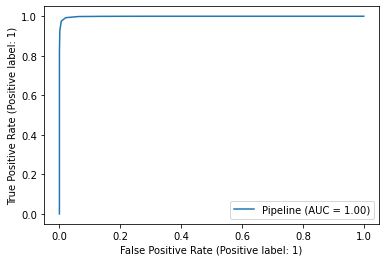

In [57]:
bag_scoring.plt_roc_curve()

In [58]:
xgc = XGBClassifier(random_state=42, objective='binary:logistic')

In [59]:
xgc_pipe=Pipeline([('total_preprocessing',total_preprocessing), ('xgc',xgc)])

In [60]:
xgc_pipe.fit(X_train,y_train)

Pipeline(steps=[('total_preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                      

In [61]:
xgc_scoring=ModelWithAOCROC(xgc_pipe, 'xcg_pipe', X_train, y_train, cv_now=True)

In [62]:
xgc_scoring.print_cv_summary()

CV Results for `xcg_pipe` model:
            0.77466 ± 0.01267 accuracy
        


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


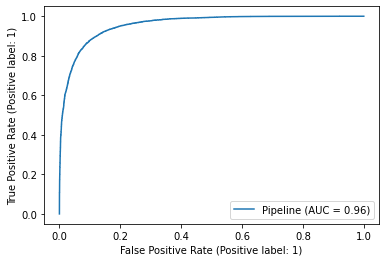

In [63]:
xgc_scoring.plt_roc_curve()

In [84]:
stc = StackingClassifier(estimators=[
    ('gbc', GradientBoostingClassifier(random_state=42)),
    ('log_reg', LogisticRegression(max_iter=1000)),
    
])
stc_pipe= Pipeline([('total_preprocessing',total_preprocessing), ('stc', stc)])

In [85]:
stc_pipe.fit(X_train,y_train)

Pipeline(steps=[('total_preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                      

In [86]:
stc_scoring=ModelWithAOCROC(stc_pipe, 'stc_pipe', X_train, y_train, cv_now=True)

In [87]:
stc_scoring.print_cv_summary()

CV Results for `stc_pipe` model:
            0.78422 ± 0.00924 accuracy
        


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


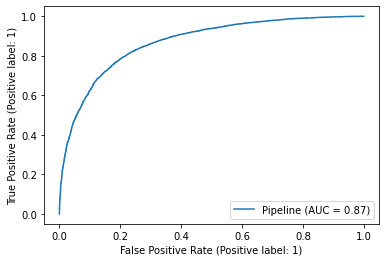

In [88]:
stc_scoring.plt_roc_curve()

In [105]:
params_log_reg={'stc__log_reg__C':[.1,1],
        'stc__log_reg__tol':[0.0001,0.001],
        'stc__log_reg__max_iter':[500,1500],
}
gs_log=GridSearchCV(stc_pipe,params_log_reg,verbose=3, cv=3,n_jobs=-1)
gs_log.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('total_preprocessing',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('standard_scaler',
                                                                                          StandardScaler()),
                                                                                         ('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['h1n1_concern',
                                                                          'h1n1_knowledge',
                                                                          'behavioral_antiviral_meds',
                                                                          'behavioral_avoidance',
                      

In [104]:
params_log_reg={'stc__log_reg__C':[.1,1,10],
        'stc__log_reg__tol':[0.001,0.01,0.1],
        'stc__log_reg__max_iter':[500,1500],
       'stc__gbc__n_estimators':[1,5],
       'stc__gbc__criterion':['friedman_mse','squared_error','mse','mae'],
       'stc__gbc__min_samples_leaf':[1,7,11],
       'stc__gbc__min_samples_split':[2,8,12]}
grid = GridSearchCV(estimator=stc_pipe, param_grid=params2,verbose=3, cv=3,n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 3 folds for each of 3888 candidates, totalling 11664 fits


KeyboardInterrupt: 

In [90]:
features_test = pd.read_csv('data/test_set_features.csv')

In [92]:
join_df = features_df.join(features_test,on='respondent_id',lsuffix='x')

In [94]:
join_df.shape

(26707, 71)

In [95]:
labels_df.shape

(26707, 2)

In [97]:
stc_pipe.fit(features_df,labels_df['seasonal_vaccine'])

Pipeline(steps=[('total_preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                      

In [98]:
stc_scoring_2 = ModelWithAOCROC(stc_pipe, 'stc_pipe', features_df, labels_df['seasonal_vaccine'], cv_now=True)

In [99]:
stc_scoring_2.print_cv_summary()

CV Results for `stc_pipe` model:
            0.78725 ± 0.00501 accuracy
        


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


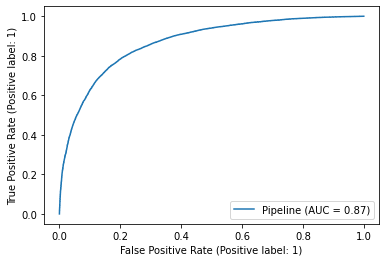

In [100]:
stc_scoring_2.plt_roc_curve()

In [101]:
y_preds = stc_pipe.predict(features_test)

In [ ]:
plot_confusion_matrix(y_)